# Análise da mistura padrão

In [1]:
import ROOT
from ROOT import gROOT, TString
from ROOT import TCanvas, TLine, TGaxis, TGraph, gPad, TF1, TF2, kRed, TMultiGraph, TLegend, gStyle, TPaveStats, TStyle, TText, TList, TLatex, TGraphErrors, TFile, TTree
import json
import math
from array import array
import numpy as np
import pandas as pd

Welcome to JupyROOT 6.30/02


In [2]:
sigma_factor = (6.2*10e-3)/1.5

def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    for scanId in scanIds:
        !echo "None" >> counter.txt
        !rm counter.txt
        path = "Scans/Scan_00"+str(scanId)+"/*_HV*_CAEN.root"
        !ls {path} >> counter.txt
        counter = np.loadtxt("counter.txt", dtype=str)
        if (str(scanId) == '5634') or (str(scanId) == '5630'):
            print("scanId = ", scanId)
            N = len(counter)
        else:
            N = len(counter)+1
        for i in range(1,N):
            jsonFile = open("Scans/Scan_00"+str(scanId)+"/ANALYSIS/KODELE/HV"+str(i)+"/output.json")
            jsonFile = json.load(jsonFile)
            histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanId)+"/Scan00"+str(scanId)+"_HV"+str(i)+"_CAEN.root","READ")
            hist_current_bot = histFile.Get("Imon_KODELE-BOT")
            hist_current_top = histFile.Get("Imon_KODELE-TOP")
            hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
            hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
            eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
            muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
            gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
            muon_CS.append(jsonFile['output_parameters']['muonCLS'])
            gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
            muon_CM.append(jsonFile['output_parameters']['muonCMP'])
            gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
            muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
            gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
            muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
            gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
            noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
            current_bot.append(hist_current_bot.GetMean())
            current_top.append(hist_current_top.GetMean())
            HV_top.append(hist_HV_top.GetMean())
            HV_bot.append(hist_HV_bot.GetMean())
            if (scanId == '5630'):
                deltaV_top.append(0.001)
                deltaV_bot.append(0.001)
            else:
                deltaV_top.append(hist_current_top.GetMean()*1.5)
                deltaV_bot.append(hist_current_bot.GetMean()*1.5)
            deltaV_top_err.append(hist_current_top.GetMean()*6.2*10e-3)
            deltaV_bot_err.append(hist_current_bot.GetMean()*6.2*10e-3)
            histFile.Close()
    DataSet = {'HV_top': HV_top, 
               'HV_bot': HV_bot, 
               'current_top': current_top, 
               'current_bot': current_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'deltaV': (np.array(deltaV_top)*np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001))/(np.array(deltaV_top)+np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001)),
               }
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV']* sigma_factor *np.sqrt( (1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2 ) / ( DataSet['current_top']+DataSet['current_bot']  ) )**2 ) ) 
    return DataSet

In [3]:
def FeaturesDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    current_bot = []
    current_top = []
    HV_top = []
    HV_bot = []
    noiseGammaRate = []
    noiseGammaRate_err = []
    for scanId in scanIds:
        print("scanID: ", scanIds[scanId][0])
        
        direc = ""
        N = "1"
        jsonFile = open("Scans/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/HV"+str(N)+"/output.json")
        histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanIds[scanId][0])+"/Scan00"+str(scanIds[scanId][0])+"_HV"+str(N)+"_CAEN.root","READ")
        hist_current_bot = histFile.Get("Imon_KODELE-BOT")
        hist_current_top = histFile.Get("Imon_KODELE-TOP")
        hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
        hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
        jsonFile = json.load(jsonFile)
        nTrig = jsonFile['output_parameters']['nTrig']
        eff.append(100*jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
        muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
        gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
        muon_CS.append(jsonFile['output_parameters']['muonCLS'])
        gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
        muon_CM.append(jsonFile['output_parameters']['muonCMP'])
        gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
        muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
        gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
        muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
        gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
        noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
        noiseGammaRate_err.append(jsonFile['output_parameters']['noiseGammaRate_err'])
        current_bot.append(hist_current_bot.GetMean())
        current_top.append(hist_current_top.GetMean())
        HV_top.append(hist_HV_top.GetMean())
        HV_bot.append(hist_HV_bot.GetMean())
    DataSet = {'current_top': current_top, 
               'current_bot': current_bot,
               'HV_top': HV_top,
               'HV_bot': HV_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'noiseGammaRate_err': noiseGammaRate_err
              }
        
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    
    return DataSet

In [4]:
sigmoid1 = TF1("sigmoid1","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid1.SetParNames("Emax","Lambda","HV50")
sigmoid1.SetParameters(0.9, 0.01, 7000)
sigmoid2 = TF1("sigmoid2","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid2.SetParNames("Emax","Lambda","HV50")
sigmoid2.SetParameters(0.9, 0.01, 7000)
sigmoid3 = TF1("sigmoid3","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid3.SetParNames("Emax","Lambda","HV50")
sigmoid3.SetParameters(0.9, 0.01, 7000)
sigmoid4 = TF1("sigmoid4","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid4.SetParNames("Emax","Lambda","HV50")
sigmoid4.SetParameters(0.9, 0.01, 7000)
sigmoid5 = TF1("sigmoid5","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid5.SetParNames("Emax","Lambda","HV50")
sigmoid5.SetParameters(0.9, 0.001, 7000)
sigmoid6 = TF1("sigmoid6","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid6.SetParNames("Emax","Lambda","HV50")
sigmoid6.SetParameters(0.9, 0.01, 7000)
sigmoid7 = TF1("sigmoid7","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid7.SetParNames("Emax","Lambda","HV50")
sigmoid7.SetParameters(0.9, 0.01, 7000)

In [5]:
# Dicionários de Scans

scans = {
    'STDMX_OFF': ['6001'],
    'STDMX_22':  ['6009'],
    'STDMX_10':  ['6011'],
    'STDMX_6.9': ['6007'],
    'STDMX_3.3': ['6014'],
    'STDMX_2.2': ['5999'],
    'STDMX_1':   ['6005']
}

Scans_STDMX = {
    'STDMX_OFF':  ['6004'],
    'STDMX_22':   ['6010'],
    'STDMX_10':   ['6012'],
    'STDMX_6.9':  ['6008'],
    'STDMX_3.3':  ['6003'],
    'STDMX_2.2':  ['6000'],
    'STDMX_1':    ['6006']
}

# Listas de Scans
scans_STDMX = [
    ['STDMX_OFF', sigmoid1, 6, 23],
    ['STDMX_22', sigmoid2, 6, 23],
    ['STDMX_10', sigmoid3, 3, 22],
    ['STDMX_6.9', sigmoid4, 3, 22],
    ['STDMX_3.3', sigmoid5, 2, 20],
    ['STDMX_2.2', sigmoid6, 2, 20],
    ['STDMX_1', sigmoid7, 4, 21],
]

In [6]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

STDMX_OFF : 


   HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0  6300.0  6300.0     2.968333     0.200000     0.000959      0.000000   
1  6500.0  6500.0     3.472696     0.200000     0.001931      0.000000   
2  6700.0  6700.0     3.953333     0.200000     0.005479      0.000000   
3  6900.0  6900.0     4.851667     0.400000     0.012658      0.000000   
4  7100.0  7100.0     5.250000     0.521667     0.022967      0.000544   
5  7200.0  7200.0     5.528333     0.611667     0.015640      0.000273   
6  7300.0  7300.0     5.916667     1.046667     0.032015      0.000000   
7  7400.0  7400.0     6.770000     1.170000     0.036310      0.001231   
8  7500.0  7500.0     7.435000     1.315000     0.048372      0.000549   
9  7600.0  7600.0     8.281667     1.543333     0.073171      0.000827   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.000000  1.413043  2.777778  1.307692     0.111111      0.000000   
1  1.000000  1.303030  1.500000  1.383721

In [7]:
Features_STDMX = FeaturesDataFrame(Scans_STDMX)
Features_STDMX['gamma_CM'][0] = 1
Features_STDMX['gamma_CS'][0] = 1
Features_STDMX['noiseGammaRate'][0] = 1
print("Features_STDMX = ", Features_STDMX)
Features_STDMX

scanID:  6004
scanID:  6010
scanID:  6012
scanID:  6008
scanID:  6003
scanID:  6000
scanID:  6006
Features_STDMX =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     5.313766     0.644304  7211.0  7211.0     0.022815      0.000349   
1    11.824855     5.854651  7225.0  7225.0     0.022033      0.009271   
2    16.713228    10.164021  7205.0  7205.0     0.020609      0.014452   
3    21.521959    13.846622  7184.0  7184.0     0.017764      0.017449   
4    38.678479    28.631263  7228.0  7228.0     0.015074      0.034067   
5    49.505268    37.116439  7253.0  7253.0     0.012992      0.040892   
6    85.512302    68.834573  7255.0  7255.0     0.008492      0.052683   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.066282   1.000000  1.980631  1.000000     0.129971      0.043425   
1  1.083988   1.841353  1.978912  1.757396     0.133687      0.124262   
2  1.098027   2.726487  1.878130  1.698394     0.113665      0.170454   

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,5.313766,0.644304,7211.0,7211.0,0.022815,0.000349,1.066282,1.000000,1.980631,1.000000,0.129971,0.043425,0.215193,0.031539,97.973700,0.001367,1.000000,2.723515,5.958070
1,11.824855,5.854651,7225.0,7225.0,0.022033,0.009271,1.083988,1.841353,1.978912,1.757396,0.133687,0.124262,0.217262,0.111099,96.779154,0.001755,231.584872,15.194404,17.679506
2,16.713228,10.164021,7205.0,7205.0,0.020609,0.014452,1.098027,2.726487,1.878130,1.698394,0.113665,0.170454,0.176181,0.099932,95.869403,0.001997,419.112290,20.450220,26.877249
3,21.521959,13.846622,7184.0,7184.0,0.017764,0.017449,1.127487,3.764902,1.784291,1.645668,0.102567,0.225465,0.148781,0.092984,94.923568,0.002213,597.624512,24.423991,35.368581
4,38.678479,28.631263,7228.0,7228.0,0.015074,0.034067,1.178133,7.562873,1.794742,1.638683,0.115748,0.438186,0.160554,0.089744,93.155167,0.002542,1226.948148,35.000773,67.309743
5,49.505268,37.116439,7253.0,7253.0,0.012992,0.040892,1.210143,9.936350,1.772504,1.630574,0.108600,0.571653,0.145967,0.088706,91.712543,0.002774,1603.483514,40.012146,86.621707
6,85.512302,68.834573,7255.0,7255.0,0.008492,0.052683,1.337061,19.460373,1.590971,1.516138,0.090256,0.964834,0.100604,0.071618,88.130626,0.003247,2919.378560,53.993973,154.346875


Total de scans no dicionário: 7
Processando scan: STDMX_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.011351885629587432
HV95_err = 8.410156417018278
Fit concluído para o scan: STDMX_OFF
Processando scan: STDMX_22
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.01052155972016495
HV95_err = 9.60769235352853
Fit concluído para o scan: STDMX_22
Processando scan: STDMX_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.011664840401509271
HV95_err = 8.494364229648463
Fit concluído para o scan: STDMX_10
Processando scan: STDMX_6.9
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.012267338075199157
HV95_err = 8.572669659430025
Fit concluído para o scan: STDMX_6.9
Processando scan: STDMX_3.3
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.01149550908835804
HV95_err = 5.303592232622414
Fit concluído para o scan: STDMX_3.3
Processando scan: STDMX_2.2
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.011001156735349647
HV95_err = 10.0858986794466

Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6170.000000,7730.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6170.000000,7730.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 6170 xmax = 7730 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [6170.000000,7730.000000] is not a valid interval
Info in <ROOT::Math::B

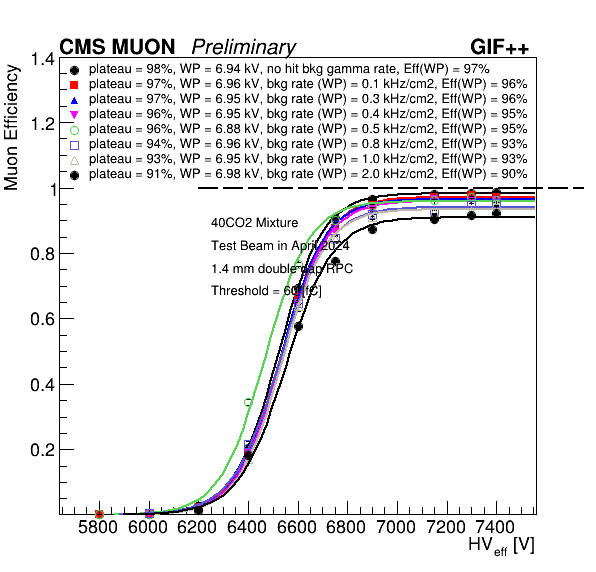

In [8]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine
import math

# Inicializando listas para gráficos e funções
TGraphs_list_STDMX = []
func_list_STDMX = []

# Cores e estilos de marcadores
colors = [1, 2, 4, 6, 8, 9, 11]  # Preto, Vermelho, Azul, Laranja, Rosa, Verde, Amarelo
markers = [20, 21, 22, 23, 24, 25, 26]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_STDMX)
print(f"Total de scans no dicionário: {num_scans_total}")

for idx, (scan, sigmoid, color, marker) in enumerate(scans_STDMX):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Configurando cor e marcador
    gr_E.SetMarkerColor(colors[idx % len(colors)])
    gr_E.SetMarkerStyle(markers[idx % len(markers)])
    sig.SetLineColor(colors[idx % len(colors)])
    
    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_STDMX.append(gr_E)
    func_list_STDMX.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_STDMX:
    TGraphs_list_STDMX[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_STDMX[0].SetTitle("")
    TGraphs_list_STDMX[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_STDMX[0].GetYaxis().SetTitle("Muon Efficiency")
    TGraphs_list_STDMX[0].Draw("AP")
    
    for graph in TGraphs_list_STDMX[1:]:
        graph.Draw("PSAME")

    Emax_STDMX = []
    Emax_err_STDMX = []
    Lambda_STDMX = []
    Lambda_err_STDMX = []
    HV50_STDMX = []
    HV50_err_STDMX = []
    HV95_STDMX = []
    HV95_err_STDMX = []

    for sig in func_list_STDMX:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_STDMX.append(Emax_)
        Emax_err_STDMX.append(sig.GetParError(0))     
        Lambda_STDMX.append(sig.GetParameter(1))  
        Lambda_err_STDMX.append(sig.GetParError(1))
        HV50_STDMX.append(sig.GetParameter(2))  
        HV50_err_STDMX.append(sig.GetParError(2)) 
        HV95_STDMX.append(sig.GetX(HV_ref))
        HV95_err_STDMX.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_STDMX = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_STDMX, Lambda_STDMX, HV50_STDMX):
        WP_STDMX.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_STDMX_OFF = Features_STDMX['noiseGammaRate'][0] / (Features_STDMX['gamma_CS'][1] * 1000)
    txt_STDMX_22 = Features_STDMX['noiseGammaRate'][1] / (Features_STDMX['gamma_CS'][1] * 1000)
    txt_STDMX_10 = Features_STDMX['noiseGammaRate'][2] / (Features_STDMX['gamma_CS'][2] * 1000)
    txt_STDMX_6_9 = Features_STDMX['noiseGammaRate'][3] / (Features_STDMX['gamma_CS'][3] * 1000)
    #txt_STDMX_4_6 = Features_STDMX['noiseGammaRate'][4] / (Features_STDMX['gamma_CS'][1] * 1000) (Não tem o scan de source 4.6)
    txt_STDMX_3_3 = Features_STDMX['noiseGammaRate'][4] / (Features_STDMX['gamma_CS'][4] * 1000)
    txt_STDMX_2_2 = Features_STDMX['noiseGammaRate'][5] / (Features_STDMX['gamma_CS'][5] * 1000)
    txt_STDMX_1 = Features_STDMX['noiseGammaRate'][6] / (Features_STDMX['gamma_CS'][6] * 1000)

     # Source OFF
    eff_1_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format( a=Emax_STDMX[0], b=WP_STDMX[0] / 1000., 
                                                                                                        c=(func_list_STDMX[0].Eval(WP_STDMX[0])))
    # Source 22
    eff_2_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[1], b=WP_STDMX[1] / 1000., 
                                                                                                                  c=(func_list_STDMX[1].Eval(WP_STDMX[1])), 
                                                                                                                  d=txt_STDMX_22)
    # Source 10
    eff_3_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[2], b=WP_STDMX[2] / 1000., 
                                                                                                                  c=(func_list_STDMX[2].Eval(WP_STDMX[2])), 
                                                                                                                  d=txt_STDMX_10)
    # Source 6.9
    eff_4_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[3], b=WP_STDMX[3] / 1000., 
                                                                                                                  c=(func_list_STDMX[3].Eval(WP_STDMX[3])), 
                                                                                                                  d=txt_STDMX_6_9)
    # Source 3.3
    eff_5_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[4], b=WP_STDMX[4] / 1000., 
                                                                                                                  c=(func_list_STDMX[4].Eval(WP_STDMX[4])), 
                                                                                                                  d=txt_STDMX_3_3)
    # Source 2.2
    eff_6_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[5], b=WP_STDMX[5] / 1000., 
                                                                                                                  c=(func_list_STDMX[5].Eval(WP_STDMX[5])), 
                                                                                                                  d=txt_STDMX_2_2)
    # Source 1
    eff_7_STDMX = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_STDMX[6], b=WP_STDMX[6] / 1000., 
                                                                                                                  c=(func_list_STDMX[6].Eval(WP_STDMX[6])), 
                                                                                                                  d=txt_STDMX_1)
    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6250, 0.88, "Standard Mixture")
    ltx_data.DrawLatex(6250, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6250, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6250, 0.67, "Threshold = 60 [fC]")

    line = TLine(6200, 1., 7750, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_STDMX[0], eff_1_STDMX, "p")  # Triângulo para baixo rosa
    legend.AddEntry(TGraphs_list_STDMX[1], eff_2_STDMX, "p")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_STDMX[2], eff_3_STDMX, "p")  # Bolinha vermelha
    legend.AddEntry(TGraphs_list_STDMX[3], eff_4_STDMX, "p")  # Estrela preta
    legend.AddEntry(TGraphs_list_STDMX[4], eff_5_STDMX, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_STDMX[5], eff_6_STDMX, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_STDMX[5], eff_7_STDMX, "p")  # Bolinha azul

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("STDMX_eff.png")
canvas_all.SaveAs("STDMX_eff.pdf")
canvas_all.SaveAs("STDMX_eff.root")


# Analise da mistura 30% CO2 + 1% SF6

In [9]:
import ROOT
from ROOT import gROOT, TString
from ROOT import TCanvas, TLine, TGaxis, TGraph, gPad, TF1, TF2, kRed, TMultiGraph, TLegend, gStyle, TPaveStats, TStyle, TText, TList, TLatex, TGraphErrors, TFile, TTree
import json
import math
from array import array
import numpy as np
import pandas as pd

In [10]:
sigma_factor = (6.2*10e-3)/1.5

def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    for scanId in scanIds:
        !echo "None" >> counter.txt
        !rm counter.txt
        path = "Scans/Scan_00"+str(scanId)+"/*_HV*_CAEN.root"
        !ls {path} >> counter.txt
        counter = np.loadtxt("counter.txt", dtype=str)
        if (str(scanId) == '5634') or (str(scanId) == '5630'):
            print("scanId = ", scanId)
            N = len(counter)
        else:
            N = len(counter)+1
        for i in range(1,N):
            jsonFile = open("Scans/Scan_00"+str(scanId)+"/ANALYSIS/KODELE/HV"+str(i)+"/output.json")
            jsonFile = json.load(jsonFile)
            histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanId)+"/Scan00"+str(scanId)+"_HV"+str(i)+"_CAEN.root","READ")
            hist_current_bot = histFile.Get("Imon_KODELE-BOT")
            hist_current_top = histFile.Get("Imon_KODELE-TOP")
            hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
            hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
            eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
            muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
            gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
            muon_CS.append(jsonFile['output_parameters']['muonCLS'])
            gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
            muon_CM.append(jsonFile['output_parameters']['muonCMP'])
            gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
            muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
            gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
            muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
            gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
            noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
            current_bot.append(hist_current_bot.GetMean())
            current_top.append(hist_current_top.GetMean())
            HV_top.append(hist_HV_top.GetMean())
            HV_bot.append(hist_HV_bot.GetMean())
            if (scanId == '5630'):
                deltaV_top.append(0.001)
                deltaV_bot.append(0.001)
            else:
                deltaV_top.append(hist_current_top.GetMean()*1.5)
                deltaV_bot.append(hist_current_bot.GetMean()*1.5)
            deltaV_top_err.append(hist_current_top.GetMean()*6.2*10e-3)
            deltaV_bot_err.append(hist_current_bot.GetMean()*6.2*10e-3)
            histFile.Close()
    DataSet = {'HV_top': HV_top, 
               'HV_bot': HV_bot, 
               'current_top': current_top, 
               'current_bot': current_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'deltaV': (np.array(deltaV_top)*np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001))/(np.array(deltaV_top)+np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001)),
               }
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV']* sigma_factor *np.sqrt( (1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2 ) / ( DataSet['current_top']+DataSet['current_bot']  ) )**2 ) ) 
    return DataSet

In [11]:
def FeaturesDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    current_bot = []
    current_top = []
    HV_top = []
    HV_bot = []
    noiseGammaRate = []
    noiseGammaRate_err = []
    for scanId in scanIds:
        print("scanID: ", scanIds[scanId][0])
        
        direc = ""
        N = "1"
        jsonFile = open("Scans/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/HV"+str(N)+"/output.json")
        histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanIds[scanId][0])+"/Scan00"+str(scanIds[scanId][0])+"_HV"+str(N)+"_CAEN.root","READ")
        hist_current_bot = histFile.Get("Imon_KODELE-BOT")
        hist_current_top = histFile.Get("Imon_KODELE-TOP")
        hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
        hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
        jsonFile = json.load(jsonFile)
        nTrig = jsonFile['output_parameters']['nTrig']
        eff.append(100*jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
        muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
        gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
        muon_CS.append(jsonFile['output_parameters']['muonCLS'])
        gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
        muon_CM.append(jsonFile['output_parameters']['muonCMP'])
        gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
        muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
        gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
        muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
        gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
        noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
        noiseGammaRate_err.append(jsonFile['output_parameters']['noiseGammaRate_err'])
        current_bot.append(hist_current_bot.GetMean())
        current_top.append(hist_current_top.GetMean())
        HV_top.append(hist_HV_top.GetMean())
        HV_bot.append(hist_HV_bot.GetMean())
    DataSet = {'current_top': current_top, 
               'current_bot': current_bot,
               'HV_top': HV_top,
               'HV_bot': HV_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'noiseGammaRate_err': noiseGammaRate_err
              }
        
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    
    return DataSet

In [12]:
sigmoid1 = TF1("sigmoid1","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid1.SetParNames("Emax","Lambda","HV50")
sigmoid1.SetParameters(0.9, 0.01, 7000)
sigmoid2 = TF1("sigmoid2","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid2.SetParNames("Emax","Lambda","HV50")
sigmoid2.SetParameters(0.9, 0.01, 7000)
sigmoid3 = TF1("sigmoid3","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid3.SetParNames("Emax","Lambda","HV50")
sigmoid3.SetParameters(0.9, 0.01, 7000)
sigmoid4 = TF1("sigmoid4","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid4.SetParNames("Emax","Lambda","HV50")
sigmoid4.SetParameters(0.9, 0.01, 7000)
sigmoid5 = TF1("sigmoid5","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid5.SetParNames("Emax","Lambda","HV50")
sigmoid5.SetParameters(0.9, 0.001, 7000)

In [13]:
scans = {
    '30CO2_OFF':      ['6019'],
    '30CO2_22':       ['6021'],
    '30CO2_10':       ['6015'],
    '30CO2_3.3':      ['6023'],
    '30CO2_2.2':      ['6025'],
    '30CO2_1':        ['6027'],
}

Scans_30CO2 = {
    '30CO2_OFF':  ['6029'],
    '30CO2_22':   ['6022'],
    '30CO2_10':   ['6020'],
    '30CO2_3.3':  ['6024'],
    '30CO2_2.2':  ['6026'],
    '30CO2_1':    ['6028']
}
# Listas de Scans
scans_30CO2 = [
    ['30CO2_OFF', sigmoid1, 6, 23],
    ['30CO2_22', sigmoid2, 4, 20],
    ['30CO2_10', sigmoid3, 3, 22],
    ['30CO2_3.3', sigmoid4, 2, 20],
    ['30CO2_2.2', sigmoid5, 4, 20],
    ['30CO2_1', sigmoid6, 4, 21],
]

In [14]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

30CO2_OFF : 


   HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0  6100.0  6100.0     2.976667     0.200000     0.000000      0.000000   
1  6300.0  6300.0     3.441177     0.200000     0.000000      0.000500   
2  6500.0  6500.0     3.800000     0.338333     0.000000      0.000000   
3  6700.0  6700.0     4.390476     0.626984     0.019627      0.000732   
4  6900.0  6900.0     4.980952     0.928571     0.023719      0.000000   
5  7000.0  7000.0     5.561667     1.108333     0.024950      0.000748   
6  7100.0  7100.0     5.905000     1.258333     0.039623      0.001100   
7  7200.0  7200.0     6.635000     1.506667     0.043180      0.000275   
8  7300.0  7300.0     7.100000     1.739437     0.063315      0.000978   
9  7400.0  7400.0     7.793333     2.278333     0.069133      0.001382   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.166667  1.080000  2.714286  1.259259     0.333333      0.080000   
1  1.260870  1.068182  1.482759  1.404255

In [15]:
Features_30CO2 = FeaturesDataFrame(Scans_30CO2)
Features_30CO2['gamma_CM'][0] = 1
Features_30CO2['gamma_CS'][0] = 1
Features_30CO2['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_30CO2) = ", FeaturesDataFrame(Scans_30CO2))
Features_30CO2

scanID:  6029
scanID:  6022
scanID:  6020
scanID:  6024
scanID:  6026
scanID:  6028
scanID:  6029
scanID:  6022
scanID:  6020
scanID:  6024
scanID:  6026
scanID:  6028
FeaturesDataFrame(Scans_30CO2) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     5.608386     1.084494  7016.0  7016.0     0.028245      0.000625   
1    11.684006     7.259366  7033.0  7033.0     0.024372      0.007969   
2    17.694387    12.501436  7033.0  7033.0     0.022578      0.013724   
3    40.615864    33.084136  7036.0  7036.0     0.014848      0.028279   
4    50.736454    42.571414  7048.0  7048.0     0.011651      0.032018   
5    91.335851    79.616320  7077.0  7077.0     0.007291      0.046054   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.073034   1.455137  1.961330  1.401251     0.092450      0.049415   
1  1.086223   1.828670  1.931012  1.716499     0.091307      0.114045   
2  1.103060   2.771144  1.890583  1.693274     0.085529     

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,5.608386,1.084494,7016.0,7016.0,0.028245,0.000625,1.073034,1.000000,1.961330,1.000000,0.092450,0.049415,0.155579,0.046022,96.962091,0.001678,1.000000,2.637284,6.692880
1,11.684006,7.259366,7033.0,7033.0,0.024372,0.007969,1.086223,1.828670,1.931012,1.716499,0.091307,0.114045,0.149732,0.100765,95.907904,0.001957,225.230859,14.992862,18.943372
2,17.694387,12.501436,7033.0,7033.0,0.022578,0.013724,1.103060,2.771144,1.890583,1.693274,0.085529,0.166796,0.136043,0.096132,94.898226,0.002159,426.595633,20.637899,30.195822
3,40.615864,33.084136,7036.0,7036.0,0.014848,0.028279,1.169665,7.458290,1.738561,1.598497,0.081945,0.403556,0.113827,0.082052,90.960855,0.002884,1179.798388,34.325899,73.700000
4,50.736454,42.571414,7048.0,7048.0,0.011651,0.032018,1.207975,9.760137,1.707813,1.570308,0.085558,0.502509,0.112960,0.076890,90.055238,0.003004,1517.505891,38.931149,93.307869
5,91.335851,79.616320,7077.0,7077.0,0.007291,0.046054,1.330067,19.246791,1.570426,1.483980,0.075167,0.903831,0.084003,0.066562,87.075796,0.003365,2825.160419,53.123884,170.952170


In [16]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine
import math

# Inicializando listas para gráficos e funções
TGraphs_list_30CO2 = []
func_list_30CO2 = []

# Cores e estilos de marcadores
colors = [1, 2, 4, 6, 8, 9, 11]  # Preto, Vermelho, Azul, Laranja, Rosa, Verde, Amarelo
markers = [20, 21, 22, 23, 24, 25, 26]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

for idx, (scan, sigmoid, color, marker) in enumerate(scans_30CO2):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Configurando cor e marcador
    gr_E.SetMarkerColor(colors[idx % len(colors)])
    gr_E.SetMarkerStyle(markers[idx % len(markers)])
    sig.SetLineColor(colors[idx % len(colors)])
    
    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_30CO2.append(gr_E)
    func_list_30CO2.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_30CO2:
    TGraphs_list_30CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO2[0].SetTitle("")
    TGraphs_list_30CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO2[0].GetYaxis().SetTitle("Muon Efficiency")
    TGraphs_list_30CO2[0].Draw("AP")
    
    for graph in TGraphs_list_30CO2[1:]:
        graph.Draw("PSAME")

    Emax_30CO2 = []
    Emax_err_30CO2 = []
    Lambda_30CO2 = []
    Lambda_err_30CO2 = []
    HV50_30CO2 = []
    HV50_err_30CO2 = []
    HV95_30CO2 = []
    HV95_err_30CO2 = []

    for sig in func_list_30CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO2.append(Emax_)
        Emax_err_30CO2.append(sig.GetParError(0))     
        Lambda_30CO2.append(sig.GetParameter(1))  
        Lambda_err_30CO2.append(sig.GetParError(1))
        HV50_30CO2.append(sig.GetParameter(2))  
        HV50_err_30CO2.append(sig.GetParError(2)) 
        HV95_30CO2.append(sig.GetX(HV_ref))
        HV95_err_30CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_30CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO2, Lambda_30CO2, HV50_30CO2):
        WP_30CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO2_OFF = Features_30CO2['noiseGammaRate'][0] / (Features_30CO2['gamma_CS'][1] * 1000)
    txt_30CO2_22 = Features_30CO2['noiseGammaRate'][1] / (Features_30CO2['gamma_CS'][1] * 1000)
    txt_30CO2_10 = Features_30CO2['noiseGammaRate'][2] / (Features_30CO2['gamma_CS'][2] * 1000)
    #txt_30CO2_6_9 = Features_30CO2['noiseGammaRate'][3] / (Features_30CO2['gamma_CS'][3] * 1000)
    #txt_30CO2_4_6 = Features_30CO2['noiseGammaRate'][4] / (Features_30CO2['gamma_CS'][1] * 1000) (Não tem o scan de source 4.6)
    txt_30CO2_3_3 = Features_30CO2['noiseGammaRate'][3] / (Features_30CO2['gamma_CS'][3] * 1000)
    txt_30CO2_2_2 = Features_30CO2['noiseGammaRate'][4] / (Features_30CO2['gamma_CS'][4] * 1000)
    txt_30CO2_1 = Features_30CO2['noiseGammaRate'][5] / (Features_30CO2['gamma_CS'][5] * 1000)

    # Formatação das strings de eficiência para 30CO2
    eff_1_30CO2_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[0], b=WP_30CO2[0] / 1000., 
                                                                                                        c=(func_list_30CO2[0].Eval(WP_30CO2[0])))
    eff_2_30CO2_22 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[1], b=WP_30CO2[1] / 1000., 
                                                                                                                  c=(func_list_30CO2[1].Eval(WP_30CO2[1])), 
                                                                                                                  d=txt_30CO2_22)
    eff_3_30CO2_10 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[2], b=WP_30CO2[2] / 1000., 
                                                                                                                  c=(func_list_30CO2[2].Eval(WP_30CO2[2])), 
                                                                                                                  d=txt_30CO2_10)
    eff_5_30CO2_3_3 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[3], b=WP_30CO2[3] / 1000., 
                                                                                                                  c=(func_list_30CO2[3].Eval(WP_30CO2[3])), 
                                                                                                                  d=txt_30CO2_3_3)
    eff_6_30CO2_2_2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[4], b=WP_30CO2[4] / 1000., 
                                                                                                                  c=(func_list_30CO2[4].Eval(WP_30CO2[4])), 
                                                                                                                  d=txt_30CO2_2_2)
    eff_7_30CO2_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO2[5], b=WP_30CO2[5] / 1000., 
                                                                                                                  c=(func_list_30CO2[5].Eval(WP_30CO2[5])), 
                                                                                                                  d=txt_30CO2_1)

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6250, 0.88, "30CO2 Mixture")
    ltx_data.DrawLatex(6250, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6250, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6250, 0.67, "Threshold = 60 [fC]")

    line = TLine(6200, 1., 7750, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_30CO2[0], eff_1_30CO2_OFF, "p")  # Triângulo para baixo rosa
    legend.AddEntry(TGraphs_list_30CO2[1], eff_2_30CO2_22, "p")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_30CO2[2], eff_3_30CO2_10, "p")  # Bolinha vermelha
    #legend.AddEntry(TGraphs_list_30CO2[3], eff_4_30CO2, "p")  # Estrela preta
    legend.AddEntry(TGraphs_list_30CO2[3], eff_5_30CO2_3_3, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO2[4], eff_6_30CO2_2_2, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO2[5], eff_7_30CO2_1, "p")  # Bolinha azul

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("30CO2_eff.png")
canvas_all.SaveAs("30CO2_eff.pdf")
canvas_all.SaveAs("30CO2_eff.root")

Total de scans no dicionário: 6
Processando scan: 30CO2_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.011106450315739716
HV95_err = 8.585883077313833
Fit concluído para o scan: 30CO2_OFF
Processando scan: 30CO2_22
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.01071624872447307
HV95_err = 9.184203275093134
Fit concluído para o scan: 30CO2_22
Processando scan: 30CO2_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.01055030752940148
HV95_err = 9.967908273253713
Fit concluído para o scan: 30CO2_10
Processando scan: 30CO2_3.3
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.0119776338302702
HV95_err = 9.1983853113182
Fit concluído para o scan: 30CO2_3.3
Processando scan: 30CO2_2.2
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.01125522605616486
HV95_err = 9.701567297523438
Fit concluído para o scan: 30CO2_2.2
Processando scan: 30CO2_1
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.010492280256754645
HV95_err = 11.291753150887477
Fit

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5970 xmax = 7530 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5970.000000,7530.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5970 xmax = 7530 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5970.000000,7530.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5980 xmax = 7420 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [59

# Análise para 30% C02 + 05% SF6

In [17]:
import ROOT
from ROOT import gROOT, TString
from ROOT import TCanvas, TLine, TGaxis, TGraph, gPad, TF1, TF2, kRed, TMultiGraph, TLegend, gStyle, TPaveStats, TStyle, TText, TList, TLatex, TGraphErrors, TFile, TTree
import json
import math
from array import array
import numpy as np
import pandas as pd

In [18]:
sigma_factor = (6.2*10e-3)/1.5

def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    for scanId in scanIds:
        !echo "None" >> counter.txt
        !rm counter.txt
        path = "Scans/Scan_00"+str(scanId)+"/*_HV*_CAEN.root"
        !ls {path} >> counter.txt
        counter = np.loadtxt("counter.txt", dtype=str)
        if (str(scanId) == '5634') or (str(scanId) == '5630'):
            print("scanId = ", scanId)
            N = len(counter)
        else:
            N = len(counter)+1
        for i in range(1,N):
            jsonFile = open("Scans/Scan_00"+str(scanId)+"/ANALYSIS/KODELE/HV"+str(i)+"/output.json")
            jsonFile = json.load(jsonFile)
            histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanId)+"/Scan00"+str(scanId)+"_HV"+str(i)+"_CAEN.root","READ")
            hist_current_bot = histFile.Get("Imon_KODELE-BOT")
            hist_current_top = histFile.Get("Imon_KODELE-TOP")
            hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
            hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
            eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
            muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
            gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
            muon_CS.append(jsonFile['output_parameters']['muonCLS'])
            gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
            muon_CM.append(jsonFile['output_parameters']['muonCMP'])
            gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
            muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
            gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
            muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
            gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
            noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
            current_bot.append(hist_current_bot.GetMean())
            current_top.append(hist_current_top.GetMean())
            HV_top.append(hist_HV_top.GetMean())
            HV_bot.append(hist_HV_bot.GetMean())
            if (scanId == '5630'):
                deltaV_top.append(0.001)
                deltaV_bot.append(0.001)
            else:
                deltaV_top.append(hist_current_top.GetMean()*1.5)
                deltaV_bot.append(hist_current_bot.GetMean()*1.5)
            deltaV_top_err.append(hist_current_top.GetMean()*6.2*10e-3)
            deltaV_bot_err.append(hist_current_bot.GetMean()*6.2*10e-3)
            histFile.Close()
    DataSet = {'HV_top': HV_top, 
               'HV_bot': HV_bot, 
               'current_top': current_top, 
               'current_bot': current_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'deltaV': (np.array(deltaV_top)*np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001))/(np.array(deltaV_top)+np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001)),
               }
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV']* sigma_factor *np.sqrt( (1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2 ) / ( DataSet['current_top']+DataSet['current_bot']  ) )**2 ) ) 
    return DataSet

In [19]:
def FeaturesDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    current_bot = []
    current_top = []
    HV_top = []
    HV_bot = []
    noiseGammaRate = []
    noiseGammaRate_err = []
    for scanId in scanIds:
        print("scanID: ", scanIds[scanId][0])
        
        direc = ""
        N = "1"
        jsonFile = open("Scans/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/HV"+str(N)+"/output.json")
        histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanIds[scanId][0])+"/Scan00"+str(scanIds[scanId][0])+"_HV"+str(N)+"_CAEN.root","READ")
        hist_current_bot = histFile.Get("Imon_KODELE-BOT")
        hist_current_top = histFile.Get("Imon_KODELE-TOP")
        hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
        hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
        jsonFile = json.load(jsonFile)
        nTrig = jsonFile['output_parameters']['nTrig']
        eff.append(100*jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
        muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
        gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
        muon_CS.append(jsonFile['output_parameters']['muonCLS'])
        gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
        muon_CM.append(jsonFile['output_parameters']['muonCMP'])
        gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
        muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
        gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
        muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
        gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
        noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
        noiseGammaRate_err.append(jsonFile['output_parameters']['noiseGammaRate_err'])
        current_bot.append(hist_current_bot.GetMean())
        current_top.append(hist_current_top.GetMean())
        HV_top.append(hist_HV_top.GetMean())
        HV_bot.append(hist_HV_bot.GetMean())
    DataSet = {'current_top': current_top, 
               'current_bot': current_bot,
               'HV_top': HV_top,
               'HV_bot': HV_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'noiseGammaRate_err': noiseGammaRate_err
              }
        
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    
    return DataSet

In [20]:
sigmoid1 = TF1("sigmoid1","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid1.SetParNames("Emax","Lambda","HV50")
sigmoid1.SetParameters(0.9, 0.01, 7000)
sigmoid2 = TF1("sigmoid2","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid2.SetParNames("Emax","Lambda","HV50")
sigmoid2.SetParameters(0.9, 0.01, 7000)
sigmoid3 = TF1("sigmoid3","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid3.SetParNames("Emax","Lambda","HV50")
sigmoid3.SetParameters(0.9, 0.01, 7000)
sigmoid4 = TF1("sigmoid4","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid4.SetParNames("Emax","Lambda","HV50")
sigmoid4.SetParameters(0.9, 0.01, 7000)
sigmoid5 = TF1("sigmoid5","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid5.SetParNames("Emax","Lambda","HV50")
sigmoid5.SetParameters(0.9, 0.001, 7000)
sigmoid6 = TF1("sigmoid6","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid6.SetParNames("Emax","Lambda","HV50")
sigmoid6.SetParameters(0.9, 0.01, 7000)
sigmoid7 = TF1("sigmoid7","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid7.SetParNames("Emax","Lambda","HV50")
sigmoid7.SetParameters(0.9, 0.01, 7000)

In [21]:
# Dicionários de Scans

scans = {
    '30CO205SF6_OFF': ['5981'],
    '30CO205SF6_22':  ['5985'],
    '30CO205SF6_10':  ['5979'],
    '30CO205SF6_6.9': ['5975'],
    '30CO205SF6_3.3': ['5977'],
    '30CO205SF6_2.2': ['5987'],
    '30CO205SF6_1':   ['5983'],
}
Scans_30CO205SF6 = {
    '30CO205SF6_OFF':  ['5982'],
    '30CO205SF6_22':   ['5986'],
    '30CO205SF6_10':   ['5980'],
    '30CO205SF6_6.9':  ['5973'],
    '30CO205SF6_3.3':  ['5978'],
    '30CO205SF6_2.2':  ['5988'],
    '30CO205SF6_1':    ['5984']
}
scans_30CO205SF6 = [
    ['30CO205SF6_OFF', sigmoid1, 6, 23],
    ['30CO205SF6_22', sigmoid2, 6, 23],
    ['30CO205SF6_10', sigmoid3, 3, 22],
    ['30CO205SF6_6.9', sigmoid4, 3, 22],
    ['30CO205SF6_3.3', sigmoid5, 2, 20],
    ['30CO205SF6_2.2', sigmoid6, 4, 20],
    ['30CO205SF6_1', sigmoid7, 4, 21],
]

In [22]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

30CO205SF6_OFF : 


   HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0  5800.0  5800.0     2.703333     0.200000     0.000960      0.000000   
1  6000.0  6000.0     2.800000     0.300000     0.000959      0.000000   
2  6200.0  6200.0     3.300000     0.400000     0.000964      0.000288   
3  6400.0  6400.0     3.731169     0.531169     0.002962      0.000496   
4  6600.0  6600.0     4.421667     0.901667     0.007851      0.000554   
5  6750.0  6750.0     4.906494     0.931169     0.010252      0.000746   
6  6900.0  6900.0     5.671667     1.561667     0.028656      0.000791   
7  7150.0  7150.0     7.001539     2.904615     0.038160      0.001232   
8  7300.0  7300.0     8.252703     3.475676     0.059761      0.001235   
9  7400.0  7400.0     9.477465     4.542254     0.082669      0.001470   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.200000  1.116279  2.000000  1.291667     0.000000      0.069767   
1  1.222222  1.638298  2.818182  1.259740

In [23]:
Features_30CO205SF6 = FeaturesDataFrame(Scans_30CO205SF6)
Features_30CO205SF6['gamma_CM'][0] = 1
Features_30CO205SF6['gamma_CS'][0] = 1
Features_30CO205SF6['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_30CO205SF6) = ", FeaturesDataFrame(Scans_30CO205SF6))
Features_30CO205SF6

scanID:  5982
scanID:  5986
scanID:  5980
scanID:  5973
scanID:  5978
scanID:  5988
scanID:  5984
scanID:  5982
scanID:  5986
scanID:  5980
scanID:  5973
scanID:  5978
scanID:  5988
scanID:  5984
FeaturesDataFrame(Scans_30CO205SF6) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     5.234817     1.256121  6880.0  6880.0     0.024602      0.000774   
1    11.540029     6.943208  6877.0  6877.0     0.021511      0.009172   
2    17.932998    12.872670  6902.0  6902.0     0.019166      0.017303   
3     2.900000     0.500000  5800.0  5800.0     0.000000      0.000000   
4    41.943923    33.999147  6918.0  6918.0     0.015029      0.040150   
5    54.360125    45.507307  6943.0  6943.0     0.014655      0.054613   
6    93.186709    80.099548  6946.0  6946.0     0.010345      0.061996   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.059510   1.674406  1.965578  1.441538     0.148431      0.103430   
1  1.084372   1.854575  1.

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,5.234817,1.256121,6880.0,6880.0,0.024602,0.000774,1.059510,1.000000,1.965578,1.000000,0.148431,0.103430,0.241529,0.083865,97.410406,0.001552,1.000000,3.144442,6.490938
1,11.540029,6.943208,6877.0,6877.0,0.021511,0.009172,1.084372,1.854575,1.934523,1.752546,0.142003,0.120778,0.224001,0.107155,96.408690,0.001839,232.685802,15.235289,18.483237
2,17.932998,12.872670,6902.0,6902.0,0.019166,0.017303,1.101937,2.873328,1.949138,1.766892,0.143784,0.189163,0.224974,0.109137,95.693071,0.001926,464.233932,21.520082,30.805667
3,2.900000,0.500000,5800.0,5800.0,0.000000,0.000000,1.000000,1.155340,1.000000,1.176471,0.000000,0.029126,0.000000,0.030426,0.026145,0.000493,6.618071,2.399097,3.400000
4,41.943923,33.999147,6918.0,6918.0,0.015029,0.040150,1.182952,7.878509,1.832531,1.691439,0.123186,0.481256,0.172832,0.097373,92.667782,0.002603,1318.784742,36.284340,75.943070
5,54.360125,45.507307,6943.0,6943.0,0.014655,0.054613,1.226508,10.412367,1.844713,1.691130,0.126827,0.637790,0.172876,0.097608,91.934901,0.002739,1743.599596,41.721825,99.867432
6,93.186709,80.099548,6946.0,6946.0,0.010345,0.061996,1.352047,20.180342,1.629026,1.553786,0.098944,1.055684,0.111084,0.077242,88.667013,0.002876,3100.288965,55.645419,173.286257


In [24]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine
import math

# Inicializando listas para gráficos e funções
TGraphs_list_30CO205SF6 = []
func_list_30CO205SF6 = []

# Cores e estilos de marcadores
colors = [1, 2, 4, 6, 8, 9, 11]  # Preto, Vermelho, Azul, Laranja, Rosa, Verde, Amarelo
markers = [20, 21, 22, 23, 24, 25, 26]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_30CO205SF6)
print(f"Total de scans no dicionário: {num_scans_total}")

for idx, (scan, sigmoid, color, marker) in enumerate(scans_30CO205SF6):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Configurando cor e marcador
    gr_E.SetMarkerColor(colors[idx % len(colors)])
    gr_E.SetMarkerStyle(markers[idx % len(markers)])
    sig.SetLineColor(colors[idx % len(colors)])
    
    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_30CO205SF6.append(gr_E)
    func_list_30CO205SF6.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_30CO205SF6:
    TGraphs_list_30CO205SF6[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_30CO205SF6[0].SetTitle("")
    TGraphs_list_30CO205SF6[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_30CO205SF6[0].GetYaxis().SetTitle("Muon Efficiency")
    TGraphs_list_30CO205SF6[0].Draw("AP")
    
    for graph in TGraphs_list_30CO205SF6[1:]:
        graph.Draw("PSAME")

    Emax_30CO205SF6 = []
    Emax_err_30CO205SF6 = []
    Lambda_30CO205SF6 = []
    Lambda_err_30CO205SF6 = []
    HV50_30CO205SF6 = []
    HV50_err_30CO205SF6 = []
    HV95_30CO205SF6 = []
    HV95_err_30CO205SF6 = []

    for sig in func_list_30CO205SF6:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_30CO205SF6.append(Emax_)
        Emax_err_30CO205SF6.append(sig.GetParError(0))     
        Lambda_30CO205SF6.append(sig.GetParameter(1))  
        Lambda_err_30CO205SF6.append(sig.GetParError(1))
        HV50_30CO205SF6.append(sig.GetParameter(2))  
        HV50_err_30CO205SF6.append(sig.GetParError(2)) 
        HV95_30CO205SF6.append(sig.GetX(HV_ref))
        HV95_err_30CO205SF6.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_30CO205SF6 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_30CO205SF6, Lambda_30CO205SF6, HV50_30CO205SF6):
        WP_30CO205SF6.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_30CO205SF6_OFF = Features_30CO205SF6['noiseGammaRate'][0] / (Features_30CO205SF6['gamma_CS'][1] * 1000)
    txt_30CO205SF6_22 = Features_30CO205SF6['noiseGammaRate'][1] / (Features_30CO205SF6['gamma_CS'][1] * 1000)
    txt_30CO205SF6_10 = Features_30CO205SF6['noiseGammaRate'][2] / (Features_30CO205SF6['gamma_CS'][2] * 1000)
    txt_30CO205SF6_6_9 = Features_30CO205SF6['noiseGammaRate'][3] / (Features_30CO205SF6['gamma_CS'][3] * 1000)
    #txt_30CO205SF6_4_6 = Features_30CO205SF6['noiseGammaRate'][4] / (Features_30CO205SF6['gamma_CS'][1] * 1000) (Não tem o scan de source 4.6)
    txt_30CO205SF6_3_3 = Features_30CO205SF6['noiseGammaRate'][4] / (Features_30CO205SF6['gamma_CS'][4] * 1000)
    txt_30CO205SF6_2_2 = Features_30CO205SF6['noiseGammaRate'][5] / (Features_30CO205SF6['gamma_CS'][5] * 1000)
    txt_30CO205SF6_1 = Features_30CO205SF6['noiseGammaRate'][6] / (Features_30CO205SF6['gamma_CS'][6] * 1000)
    print("o valor do bkg rate é: ", txt_30CO205SF6_6_9)

    if len(Emax_30CO205SF6) < 7:
        print("Lista Emax_30CO205SF6 não tem 7 elementos.")

    # Formatação das strings de eficiência para 30CO205SF6
    eff_1_30CO205SF6_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[0], b=WP_30CO205SF6[0] / 1000., 
                                                                                                        c=(func_list_30CO205SF6[0].Eval(WP_30CO205SF6[0])))
    eff_2_30CO205SF6_22 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[1], b=WP_30CO205SF6[1] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[1].Eval(WP_30CO205SF6[1])), 
                                                                                                                  d=txt_30CO205SF6_22)
    eff_3_30CO205SF6_10 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[2], b=WP_30CO205SF6[2] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[2].Eval(WP_30CO205SF6[2])), 
                                                                                                                  d=txt_30CO205SF6_10)
    eff_4_30CO205SF6_6_9 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[3], b=WP_30CO205SF6[3] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[3].Eval(WP_30CO205SF6[3])), 
                                                                                                                  d=txt_30CO205SF6_6_9)
    eff_5_30CO205SF6_3_3 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[4], b=WP_30CO205SF6[4] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[4].Eval(WP_30CO205SF6[4])), 
                                                                                                                  d=txt_30CO205SF6_3_3)
    eff_6_30CO205SF6_2_2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[5], b=WP_30CO205SF6[5] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[5].Eval(WP_30CO205SF6[5])), 
                                                                                                                  d=txt_30CO205SF6_2_2)
    eff_7_30CO205SF6_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_30CO205SF6[6], b=WP_30CO205SF6[6] / 1000., 
                                                                                                                  c=(func_list_30CO205SF6[6].Eval(WP_30CO205SF6[6])), 
                                                                                                                  d=txt_30CO205SF6_1)

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6250, 0.88, "30CO205SF6 Mixture")
    ltx_data.DrawLatex(6250, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6250, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6250, 0.67, "Threshold = 60 [fC]")

    line = TLine(6200, 1., 7750, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_30CO205SF6[0], eff_1_30CO205SF6_OFF, "p")  # Triângulo para baixo rosa
    legend.AddEntry(TGraphs_list_30CO205SF6[1], eff_2_30CO205SF6_22, "p")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_30CO205SF6[2], eff_3_30CO205SF6_10, "p")  # Bolinha vermelha
    legend.AddEntry(TGraphs_list_30CO205SF6[3], eff_4_30CO205SF6_6_9, "p")  # Estrela preta
    legend.AddEntry(TGraphs_list_30CO205SF6[4], eff_5_30CO205SF6_3_3, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO205SF6[5], eff_6_30CO205SF6_2_2, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_30CO205SF6[6], eff_7_30CO205SF6_1, "p")  # Bolinha azul

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("30CO205SF6_eff.png")
canvas_all.SaveAs("30CO205SF6_eff.pdf")
canvas_all.SaveAs("30CO205SF6_eff.root")

Total de scans no dicionário: 7
Processando scan: 30CO205SF6_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.010822660242740182
HV95_err = 8.916921930997223
Fit concluído para o scan: 30CO205SF6_OFF
Processando scan: 30CO205SF6_22
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.011338333812733145
HV95_err = 8.088036521291366
Fit concluído para o scan: 30CO205SF6_22
Processando scan: 30CO205SF6_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.010491728152681951
HV95_err = 9.325460596319505
Fit concluído para o scan: 30CO205SF6_10
Processando scan: 30CO205SF6_6.9
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.01174177574583559
HV95_err = 8.12627207204003
Fit concluído para o scan: 30CO205SF6_6.9
Processando scan: 30CO205SF6_3.3
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.010706725842915854
HV95_err = 9.137079258961759
Fit concluído para o scan: 30CO205SF6_3.3
Processando scan: 30CO205SF6_2.2
Funções no gráfico após ajuste: ['sigmoid6']
L

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56

In [33]:
print("o valor do bkg rate é: ", txt_30CO205SF6_6_9)

o valor do bkg rate é:  0.005625360023041475


# Analise para 40% C02 + 1% SF6

In [25]:
import ROOT
from ROOT import gROOT, TString
from ROOT import TCanvas, TLine, TGaxis, TGraph, gPad, TF1, TF2, kRed, TMultiGraph, TLegend, gStyle, TPaveStats, TStyle, TText, TList, TLatex, TGraphErrors, TFile, TTree
import json
import math
from array import array
import numpy as np
import pandas as pd

In [26]:
sigma_factor = (6.2*10e-3)/1.5

def HVCurrentDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    HV_top = []    
    HV_bot = []
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    noiseGammaRate = []
    deltaV_top = []
    deltaV_bot = []
    deltaV_top_err = []
    deltaV_bot_err = []
    for scanId in scanIds:
        !echo "None" >> counter.txt
        !rm counter.txt
        path = "Scans/Scan_00"+str(scanId)+"/*_HV*_CAEN.root"
        !ls {path} >> counter.txt
        counter = np.loadtxt("counter.txt", dtype=str)
        if (str(scanId) == '5634') or (str(scanId) == '5630'):
            print("scanId = ", scanId)
            N = len(counter)
        else:
            N = len(counter)+1
        for i in range(1,N):
            jsonFile = open("Scans/Scan_00"+str(scanId)+"/ANALYSIS/KODELE/HV"+str(i)+"/output.json")
            jsonFile = json.load(jsonFile)
            histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanId)+"/Scan00"+str(scanId)+"_HV"+str(i)+"_CAEN.root","READ")
            hist_current_bot = histFile.Get("Imon_KODELE-BOT")
            hist_current_top = histFile.Get("Imon_KODELE-TOP")
            hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
            hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
            eff.append(jsonFile['output_parameters']['efficiencyMuon_corrected'])
            eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
            muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
            gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
            muon_CS.append(jsonFile['output_parameters']['muonCLS'])
            gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
            muon_CM.append(jsonFile['output_parameters']['muonCMP'])
            gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
            muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
            gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
            muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
            gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
            noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
            current_bot.append(hist_current_bot.GetMean())
            current_top.append(hist_current_top.GetMean())
            HV_top.append(hist_HV_top.GetMean())
            HV_bot.append(hist_HV_bot.GetMean())
            if (scanId == '5630'):
                deltaV_top.append(0.001)
                deltaV_bot.append(0.001)
            else:
                deltaV_top.append(hist_current_top.GetMean()*1.5)
                deltaV_bot.append(hist_current_bot.GetMean()*1.5)
            deltaV_top_err.append(hist_current_top.GetMean()*6.2*10e-3)
            deltaV_bot_err.append(hist_current_bot.GetMean()*6.2*10e-3)
            histFile.Close()
    DataSet = {'HV_top': HV_top, 
               'HV_bot': HV_bot, 
               'current_top': current_top, 
               'current_bot': current_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'deltaV': (np.array(deltaV_top)*np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001))/(np.array(deltaV_top)+np.array(deltaV_bot)+np.full_like(np.array(deltaV_bot), 0.00000001)),
               }
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    DataSet['deltaV_err'] = DataSet['deltaV']* sigma_factor *np.sqrt( (1 + (np.sqrt(DataSet['current_top']**2 + DataSet['current_bot']**2 ) / ( DataSet['current_top']+DataSet['current_bot']  ) )**2 ) ) 
    return DataSet

In [27]:
def FeaturesDataFrame(scanIds):
    current_top = []    
    current_bot = []    
    eff = []
    eff_error = []
    muon_stream = []
    gamma_stream = []
    muon_CS = []
    gamma_CS = []
    muon_CM = []
    gamma_CM = []
    muon_CS_err = []
    gamma_CS_err = []
    muon_CM_err = []
    gamma_CM_err = []
    current_bot = []
    current_top = []
    HV_top = []
    HV_bot = []
    noiseGammaRate = []
    noiseGammaRate_err = []
    for scanId in scanIds:
        print("scanID: ", scanIds[scanId][0])
        
        direc = ""
        N = "1"
        jsonFile = open("Scans/Scan_00"+str(scanIds[scanId][0])+"/ANALYSIS/KODELE/HV"+str(N)+"/output.json")
        histFile  = ROOT.TFile.Open("Scans/Scan_00"+str(scanIds[scanId][0])+"/Scan00"+str(scanIds[scanId][0])+"_HV"+str(N)+"_CAEN.root","READ")
        hist_current_bot = histFile.Get("Imon_KODELE-BOT")
        hist_current_top = histFile.Get("Imon_KODELE-TOP")
        hist_HV_bot = histFile.Get("HVeff_KODELE-BOT")
        hist_HV_top = histFile.Get("HVeff_KODELE-TOP")
        jsonFile = json.load(jsonFile)
        nTrig = jsonFile['output_parameters']['nTrig']
        eff.append(100*jsonFile['output_parameters']['efficiencyMuon_corrected'])
        eff_error.append(jsonFile['output_parameters']['efficiencyMuon_corrected_err'])
        muon_stream.append(jsonFile['output_parameters']['muonStreamerProbability'])
        gamma_stream.append(jsonFile['output_parameters']['gammaStreamerProbability'])
        muon_CS.append(jsonFile['output_parameters']['muonCLS'])
        gamma_CS.append(jsonFile['output_parameters']['gammaCLS'])
        muon_CM.append(jsonFile['output_parameters']['muonCMP'])
        gamma_CM.append(jsonFile['output_parameters']['gammaCMP'])
        muon_CS_err.append(jsonFile['output_parameters']['muonCLS_err'])
        gamma_CS_err.append(jsonFile['output_parameters']['gammaCLS_err'])
        muon_CM_err.append(jsonFile['output_parameters']['muonCMP_err'])
        gamma_CM_err.append(jsonFile['output_parameters']['gammaCMP_err'])
        noiseGammaRate.append(jsonFile['output_parameters']['noiseGammaRate'])
        noiseGammaRate_err.append(jsonFile['output_parameters']['noiseGammaRate_err'])
        current_bot.append(hist_current_bot.GetMean())
        current_top.append(hist_current_top.GetMean())
        HV_top.append(hist_HV_top.GetMean())
        HV_bot.append(hist_HV_bot.GetMean())
    DataSet = {'current_top': current_top, 
               'current_bot': current_bot,
               'HV_top': HV_top,
               'HV_bot': HV_bot,
               'muon_stream': muon_stream,
               'gamma_stream': gamma_stream,
               'muon_CM': muon_CM,
               'gamma_CM': gamma_CM,
               'muon_CS': muon_CS,
               'gamma_CS': gamma_CS,
               'muon_CM_err': muon_CM_err,
               'gamma_CM_err': gamma_CM_err,
               'muon_CS_err': muon_CS_err,
               'gamma_CS_err': gamma_CS_err,
               'efficiency': eff,
               'eff_error': eff_error,
               'noiseGammaRate': noiseGammaRate,
               'noiseGammaRate_err': noiseGammaRate_err
              }
        
    DataSet = pd.DataFrame(data=DataSet)
    DataSet['current'] = DataSet['current_top'] + DataSet['current_bot']
    
    return DataSet

In [28]:
sigmoid1 = TF1("sigmoid1","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid1.SetParNames("Emax","Lambda","HV50")
sigmoid1.SetParameters(0.9, 0.01, 7000)
sigmoid2 = TF1("sigmoid2","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid2.SetParNames("Emax","Lambda","HV50")
sigmoid2.SetParameters(0.9, 0.01, 7000)
sigmoid3 = TF1("sigmoid3","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid3.SetParNames("Emax","Lambda","HV50")
sigmoid3.SetParameters(0.9, 0.01, 7000)
sigmoid4 = TF1("sigmoid4","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid4.SetParNames("Emax","Lambda","HV50")
sigmoid4.SetParameters(0.9, 0.01, 7000)
sigmoid5 = TF1("sigmoid5","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid5.SetParNames("Emax","Lambda","HV50")
sigmoid5.SetParameters(0.9, 0.001, 7000)
sigmoid6 = TF1("sigmoid6","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid6.SetParNames("Emax","Lambda","HV50")
sigmoid6.SetParameters(0.9, 0.01, 7000)
sigmoid7 = TF1("sigmoid7","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid7.SetParNames("Emax","Lambda","HV50")
sigmoid7.SetParameters(0.9, 0.01, 7000)
sigmoid8 = TF1("sigmoid8","([0]/(1+ TMath::Exp(-[1]*(x-[2]))))")
sigmoid8.SetParNames("Emax","Lambda","HV50")
sigmoid8.SetParameters(0.9, 0.01, 7000)

In [29]:
# Dicionários de Scans

scans = {
    '40CO2_OFF':      ['5959'],
    '40CO2_22':       ['5953'],
    '40CO2_10':       ['5961'],
    '40CO2_6.9':      ['5951'],
    '40CO2_4.6':      ['5947'],
    '40CO2_3.3':      ['5957'],
    '40CO2_2.2':      ['5963'],
    '40CO2_1':        ['5955']
}

Scans_40CO2 = {
    '40CO2_OFF':  ['5960'],
    '40CO2_22':   ['5954'],
    '40CO2_10':   ['5962'],
    '40CO2_6.9':  ['5952'],
    '40CO2_4.6':  ['5948'],
    '40CO2_3.3':  ['5958'],
    '40CO2_2.2':  ['5964'],
    '40CO2_1':    ['5956']
}

scans_40CO2 = [
    ['40CO2_OFF', sigmoid1, 6, 23],
    ['40CO2_22', sigmoid2, 6, 23],
    ['40CO2_10', sigmoid3, 2, 20],
    ['40CO2_6.9', sigmoid4, 1, 34],
    ['40CO2_4.6', sigmoid5, 6, 23],
    ['40CO2_3.3', sigmoid6, 4, 20],
    ['40CO2_2.2', sigmoid7, 4, 20],
    ['40CO2_1', sigmoid8, 6, 23],
]

In [30]:
for scan in scans:
    print(scan, ': ')
    print(HVCurrentDataFrame(scans[scan]))

40CO2_OFF : 


   HV_top  HV_bot  current_top  current_bot  muon_stream  gamma_stream  \
0  5800.0  5800.0     2.900000     0.200000     0.000000      0.000000   
1  6000.0  6000.0     3.223171     0.200000     0.000000      0.000000   
2  6200.0  6200.0     3.740000     0.300000     0.000483      0.000179   
3  6400.0  6400.0     4.169048     0.400000     0.003872      0.000186   
4  6600.0  6600.0     4.885714     0.604082     0.004782      0.000309   
5  6750.0  6750.0     5.389000     0.813000     0.015834      0.000461   
6  6900.0  6900.0     5.873451     1.182301     0.022972      0.000959   
7  7150.0  7150.0     7.582727     2.488182     0.041048      0.000990   
8  7300.0  7300.0     8.441379     4.057759     0.048878      0.001396   
9  7400.0  7400.0     9.737692     6.784615     0.071996      0.001748   

    muon_CM  gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0  1.000000  1.226415  2.400000  1.184615     0.200000      0.056604   
1  1.166667  1.210000  3.285714  1.239669

In [31]:
Features_40CO2 = FeaturesDataFrame(Scans_40CO2)
Features_40CO2['gamma_CM'][0] = 1
Features_40CO2['gamma_CS'][0] = 1
Features_40CO2['noiseGammaRate'][0] = 1
print("FeaturesDataFrame(Scans_40CO2) = ", FeaturesDataFrame(Scans_40CO2))
Features_40CO2

scanID:  5960
scanID:  5954
scanID:  5962
scanID:  5952
scanID:  5948
scanID:  5958
scanID:  5964
scanID:  5956
scanID:  5960
scanID:  5954
scanID:  5962
scanID:  5952
scanID:  5948
scanID:  5958
scanID:  5964
scanID:  5956
FeaturesDataFrame(Scans_40CO2) =     current_top  current_bot  HV_top  HV_bot  muon_stream  gamma_stream  \
0     5.773477     1.911591  6937.0  6937.0     0.021221      0.000344   
1    13.664417     8.953432  6957.0  6957.0     0.021621      0.009470   
2    20.327239    14.626866  6949.0  6949.0     0.020668      0.016594   
3    27.475558    20.497415  6960.0  6960.0     0.019328      0.022248   
4    35.026998    26.183909  6891.0  6891.0     0.013486      0.023490   
5    47.909940    36.917018  6964.0  6964.0     0.014772      0.039915   
6    57.014522    44.420588  6955.0  6955.0     0.012071      0.039197   
7   105.867628    86.749594  6998.0  6998.0     0.009275      0.063936   

    muon_CM   gamma_CM   muon_CS  gamma_CS  muon_CM_err  gamma_CM_err  \
0 

,current_top,current_bot,HV_top,HV_bot,muon_stream,gamma_stream,muon_CM,gamma_CM,muon_CS,gamma_CS,muon_CM_err,gamma_CM_err,muon_CS_err,gamma_CS_err,efficiency,eff_error,noiseGammaRate,noiseGammaRate_err,current
0,5.773477,1.911591,6937.0,6937.0,0.021221,0.000344,1.061569,1.000000,1.954550,1.000000,0.148102,0.078645,0.239298,0.067395,97.003308,0.001720,1.000000,3.129974,7.685069
1,13.664417,8.953432,6957.0,6957.0,0.021621,0.009470,1.080977,1.868295,1.941198,1.775234,0.149647,0.121663,0.236054,0.108535,96.119606,0.001532,240.966204,15.501642,22.617849
2,20.327239,14.626866,6949.0,6949.0,0.020668,0.016594,1.097525,2.842665,1.894031,1.765202,0.143086,0.182071,0.218448,0.106254,95.013472,0.002193,456.861310,21.349571,34.954104
3,27.475558,20.497415,6960.0,6960.0,0.019328,0.022248,1.119313,3.962864,1.868036,1.748248,0.134922,0.250250,0.200951,0.103842,94.107231,0.002083,669.595984,25.848358,47.972973
4,35.026998,26.183909,6891.0,6891.0,0.013486,0.023490,1.152742,5.490699,1.825875,1.629988,0.108438,0.311037,0.156991,0.087385,94.254399,0.001882,882.422643,29.661391,61.210907
5,47.909940,36.917018,6964.0,6964.0,0.014772,0.039915,1.172365,7.777107,1.805553,1.696698,0.119170,0.469218,0.166598,0.096543,92.634201,0.002629,1304.550107,36.089256,84.826958
6,57.014522,44.420588,6955.0,6955.0,0.012071,0.039197,1.204631,9.986851,1.708636,1.635593,0.105916,0.561977,0.138089,0.087134,91.007288,0.002875,1618.172480,40.194263,101.435110
7,105.867628,86.749594,6998.0,6998.0,0.009275,0.063936,1.350127,19.959176,1.622435,1.565827,0.095671,1.053141,0.107360,0.078480,88.570403,0.002334,3092.095717,55.572323,192.617223


In [32]:
from ROOT import TCanvas, TGraphErrors, TLegend, TLatex, TLine
import math

# Inicializando listas para gráficos e funções
TGraphs_list_40CO2 = []
func_list_40CO2 = []

# Cores e estilos de marcadores
colors = [1, 2, 4, 6, 8, 9, 11]  # Preto, Vermelho, Azul, Laranja, Rosa, Verde, Amarelo
markers = [20, 21, 22, 23, 24, 25, 26]  # Bolinha, Quadrado, Triângulo, Estrela, Cruz, X, Círculo

canvas = TCanvas("c", "c", 564, 232, 600, 600)
HV_ref = 95

k = 1

# Contagem dos scans no dicionário
num_scans_total = len(scans_40CO2)
print(f"Total de scans no dicionário: {num_scans_total}")

for idx, (scan, sigmoid, color, marker) in enumerate(scans_40CO2):
    if scan not in scans:
        print(f"Scan '{scan}' não encontrado no dicionário de scans. Pulando...")
        continue
    
    print(f"Processando scan: {scan}")
    
    df = HVCurrentDataFrame(scans[scan])
    n = len(df['HV_top'])
    
    gr_E = TGraphErrors(n, 
                        df['HV_top'].values, 
                        df['efficiency'].values,
                        0,
                        df['eff_error'].values)  # valores do df[].values para converter objeto dataframe em array adequado para o TGraph
    
    # Ajuste e verificação do resultado
    fit_result = gr_E.Fit(sigmoid, "S")
    if not fit_result.IsValid():
        print(f"Fit falhou para o scan: {scan}")
        continue
    
    # Listando funções após o ajuste para depuração
    functions = gr_E.GetListOfFunctions()
    function_names = [f.GetName() for f in functions]
    print(f"Funções no gráfico após ajuste: {function_names}")

    # Tentando encontrar a função ajustada correta
    sig = None
    for name in function_names:
        if name.startswith("sigmoid"):
            sig = gr_E.GetFunction(name)
            break
    
    if sig is None:
        print(f"Função 'sigmoid' não encontrada para o scan: {scan}. Pulando...")
        continue
    
    # Configurando cor e marcador
    gr_E.SetMarkerColor(colors[idx % len(colors)])
    gr_E.SetMarkerStyle(markers[idx % len(markers)])
    sig.SetLineColor(colors[idx % len(colors)])
    
    Emax = sig.GetParameter(0)
    Emax_err = sig.GetParError(0)     

    Lambda = sig.GetParameter(1)    
    Lambda_err = sig.GetParError(1)      

    HV50 = sig.GetParameter(2)
    HV50_err = sig.GetParError(2)      
    
    print(f"Lambda = {Lambda}")
    HV95 = sig.GetX(HV_ref)
    HV95_err = math.sqrt(((math.log(19) / Lambda**2) * Lambda_err)**2 + HV50_err**2)  # erro HV95
    
    print(f"HV95_err = {HV95_err}")

    # Adicionando gráficos e funções às listas
    TGraphs_list_40CO2.append(gr_E)
    func_list_40CO2.append(sig)
    gr_E.Draw("AP")
    k += 1

    print(f"Fit concluído para o scan: {scan}")

# Criando o canvas final
canvas_all = TCanvas("c_all", "c_all", 0, 0, 600, 600)

if TGraphs_list_40CO2:
    TGraphs_list_40CO2[0].GetHistogram().SetMaximum(1.4)
    TGraphs_list_40CO2[0].SetTitle("")
    TGraphs_list_40CO2[0].GetXaxis().SetTitle("HV_{eff} [V]")
    TGraphs_list_40CO2[0].GetYaxis().SetTitle("Muon Efficiency")
    TGraphs_list_40CO2[0].Draw("AP")
    
    for graph in TGraphs_list_40CO2[1:]:
        graph.Draw("PSAME")

    Emax_40CO2 = []
    Emax_err_40CO2 = []
    Lambda_40CO2 = []
    Lambda_err_40CO2 = []
    HV50_40CO2 = []
    HV50_err_40CO2 = []
    HV95_40CO2 = []
    HV95_err_40CO2 = []

    for sig in func_list_40CO2:
        Emax_ = 1 - math.sqrt((1 - sig.GetParameter(0)) * (1 - sig.GetParameter(0)))
        Emax_40CO2.append(Emax_)
        Emax_err_40CO2.append(sig.GetParError(0))     
        Lambda_40CO2.append(sig.GetParameter(1))  
        Lambda_err_40CO2.append(sig.GetParError(1))
        HV50_40CO2.append(sig.GetParameter(2))  
        HV50_err_40CO2.append(sig.GetParError(2)) 
        HV95_40CO2.append(sig.GetX(HV_ref))
        HV95_err_40CO2.append((math.log(19) / sig.GetParameter(1)**2) * sig.GetParError(1) + sig.GetParError(2))  # erro HV95

    WP_40CO2 = []    

    for Emax_, Lambda_, HV50_ in zip(Emax_40CO2, Lambda_40CO2, HV50_40CO2):
        WP_40CO2.append((HV50_ - math.log(1 / 0.95 - 1) / Lambda_ + 150.))

    txt_40CO2_OFF = Features_40CO2['noiseGammaRate'][0] / (Features_40CO2['gamma_CS'][0] * 1000)
    txt_40CO2_22 = Features_40CO2['noiseGammaRate'][1] / (Features_40CO2['gamma_CS'][1] * 1000)
    txt_40CO2_10 = Features_40CO2['noiseGammaRate'][2] / (Features_40CO2['gamma_CS'][2] * 1000)
    txt_40CO2_6_9 = Features_40CO2['noiseGammaRate'][3] / (Features_40CO2['gamma_CS'][3] * 1000)
    txt_40CO2_4_6 = Features_40CO2['noiseGammaRate'][4] / (Features_40CO2['gamma_CS'][4] * 1000) 
    txt_40CO2_3_3 = Features_40CO2['noiseGammaRate'][5] / (Features_40CO2['gamma_CS'][5] * 1000)
    txt_40CO2_2_2 = Features_40CO2['noiseGammaRate'][6] / (Features_40CO2['gamma_CS'][6] * 1000)
    txt_40CO2_1 = Features_40CO2['noiseGammaRate'][7] / (Features_40CO2['gamma_CS'][7] * 1000)

    if len(Emax_40CO2) < 7:
        print("Lista Emax_40CO2 não tem 7 elementos.")

    # Formatação das strings de eficiência para 40CO2
    eff_1_40CO2_OFF = 'plateau = {a:.0%}, WP = {b:.2f} kV, no hit bkg gamma rate, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[0], b=WP_40CO2[0] / 1000., 
                                                                                                        c=(func_list_40CO2[0].Eval(WP_40CO2[0])))
    eff_2_40CO2_22 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[1], b=WP_40CO2[1] / 1000., 
                                                                                                                  c=(func_list_40CO2[1].Eval(WP_40CO2[1])), 
                                                                                                                  d=txt_40CO2_22)
    eff_3_40CO2_10 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[2], b=WP_40CO2[2] / 1000., 
                                                                                                                  c=(func_list_40CO2[2].Eval(WP_40CO2[2])), 
                                                                                                                  d=txt_40CO2_10)
    eff_4_40CO2_6_9 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[3], b=WP_40CO2[3] / 1000., 
                                                                                                                  c=(func_list_40CO2[3].Eval(WP_40CO2[3])), 
                                                                                                                  d=txt_40CO2_6_9)
    eff_5_40CO2_4_6 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[4], b=WP_40CO2[4] / 1000., 
                                                                                                                  c=(func_list_40CO2[4].Eval(WP_40CO2[4])), 
                                                                                                                  d=txt_40CO2_4_6)
    eff_6_40CO2_3_3 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[5], b=WP_40CO2[5] / 1000., 
                                                                                                                  c=(func_list_40CO2[5].Eval(WP_40CO2[5])), 
                                                                                                                  d=txt_40CO2_3_3)
    eff_7_40CO2_2_2 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[6], b=WP_40CO2[6] / 1000., 
                                                                                                                  c=(func_list_40CO2[6].Eval(WP_40CO2[6])), 
                                                                                                                  d=txt_40CO2_2_2)
    eff_8_40CO2_1 = 'plateau = {a:.0%}, WP = {b:.2f} kV, bkg rate (WP) = {d:.1f} kHz/cm2, Eff(WP) = {c:.0%}'.format(a=Emax_40CO2[7], b=WP_40CO2[7] / 1000., 
                                                                                                                  c=(func_list_40CO2[7].Eval(WP_40CO2[7])), 
                                                                                                                  d=txt_40CO2_1)

    # Adicionando a legenda aos gráficos
    legend = TLegend(0.1, 0.68, 0.3, 0.89)
    legend.SetTextFont(42)
    legend.SetBorderSize(0) 
    legend.SetFillStyle(4000)
    legend.SetFillColor(0)  
    legend.SetTextSize(0.02376) 

    cms_tex = TLatex()
    cms_tex.SetNDC()
    cms_tex.SetTextFont(61)
    cms_tex.SetTextSize(0.04)
    cms_tex.SetLineWidth(2)
    cms_tex.DrawLatex(0.10, 0.905, "CMS MUON")

    cms_tex_1 = TLatex()
    cms_tex_1.SetNDC()
    cms_tex_1.SetTextFont(61)
    cms_tex_1.SetTextSize(0.04)
    cms_tex_1.SetLineWidth(2)
    cms_tex_1.DrawLatex(0.79, 0.905, "GIF++")

    cms_tex_2 = TLatex()
    cms_tex_2.SetNDC()
    cms_tex_2.SetTextFont(52)
    cms_tex_2.SetTextSize(0.04)
    cms_tex_2.SetLineWidth(2)
    cms_tex_2.DrawLatex(0.32, 0.905, "Preliminary")

    ltx_data = TLatex()
    ltx_data.SetTextFont(42)
    ltx_data.SetTextSize(0.025)
    ltx_data.SetTextColor(1)
    ltx_data.DrawLatex(6250, 0.88, "40CO2 Mixture")
    ltx_data.DrawLatex(6250, 0.81, "Test Beam in April 2024")
    ltx_data.DrawLatex(6250, 0.74, "1.4 mm double gap RPC")
    ltx_data.DrawLatex(6250, 0.67, "Threshold = 60 [fC]")

    line = TLine(6200, 1., 7750, 1.)
    line.SetLineColor(1)
    line.SetLineStyle(9)
    line.SetLineWidth(2)
    line.Draw()

    legend.AddEntry(TGraphs_list_40CO2[0], eff_1_40CO2_OFF, "p")  # Triângulo para baixo rosa
    legend.AddEntry(TGraphs_list_40CO2[1], eff_2_40CO2_22, "p")  # Triângulo para cima verde
    legend.AddEntry(TGraphs_list_40CO2[2], eff_3_40CO2_10, "p")  # Bolinha vermelha
    legend.AddEntry(TGraphs_list_40CO2[3], eff_4_40CO2_6_9, "p")  # Estrela preta
    legend.AddEntry(TGraphs_list_40CO2[4], eff_5_40CO2_4_6, "p")  # Estrela preta
    legend.AddEntry(TGraphs_list_40CO2[5], eff_6_40CO2_3_3, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_40CO2[6], eff_7_40CO2_2_2, "p")  # Bolinha azul
    legend.AddEntry(TGraphs_list_40CO2[7], eff_8_40CO2_1, "p")  # Bolinha azul

    legend.Draw()

    print("Gráficos e legendas adicionados ao canvas.")

# Salvar ou mostrar o canvas
canvas_all.SaveAs("40CO2_eff.png")
canvas_all.SaveAs("40CO2_eff.pdf")
canvas_all.SaveAs("40CO2_eff.root")


Total de scans no dicionário: 8
Processando scan: 40CO2_OFF
Funções no gráfico após ajuste: ['sigmoid1']
Lambda = 0.011081050738083293
HV95_err = 6.013319486034183
Fit concluído para o scan: 40CO2_OFF
Processando scan: 40CO2_22
Funções no gráfico após ajuste: ['sigmoid2']
Lambda = 0.010807905969701962
HV95_err = 6.281344235928859
Fit concluído para o scan: 40CO2_22
Processando scan: 40CO2_10
Funções no gráfico após ajuste: ['sigmoid3']
Lambda = 0.011087681854931055
HV95_err = 9.160574936221103
Fit concluído para o scan: 40CO2_10
Processando scan: 40CO2_6.9
Funções no gráfico após ajuste: ['sigmoid4']
Lambda = 0.01100290715511471
HV95_err = 5.033432953093114
Fit concluído para o scan: 40CO2_6.9
Processando scan: 40CO2_4.6
Funções no gráfico após ajuste: ['sigmoid5']
Lambda = 0.011102854246325072
HV95_err = 4.587316955079903
Fit concluído para o scan: 40CO2_4.6
Processando scan: 40CO2_3.3
Funções no gráfico após ajuste: ['sigmoid6']
Lambda = 0.01046732295380113
HV95_err = 6.5787729295119

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [5640.000000,7560.000000] is not a valid interval
Info in <ROOT::Math::BrentMethods::MinimStep>: Grid search failed to find a root in the  interval 
Info in <ROOT::Math::BrentMethods::MinimStep>: xmin = 5640 xmax = 7560 npts = 100
Error in <ROOT::Math::BrentRootFinder>: Interval does not contain a root
Error in <TF1::GetX>: [56